# Overview

This notebook presents several classifiers aiming to predict startups success (aquired or failed, no IPO data in the imput dataset) based on the avaliable data.
 For the input data analysis, please view EDA notebood in the same repository.
 The dataset can be found here: https://www.kaggle.com/datasets/manishkc06/startup-success-prediction/data

 # Take code from git

In [1]:
# !rm -r Applied_DS_Project # pay attention!
# !git clone https://github.com/MayaVB/Applied_DS_Project.git

In [2]:
# !ls Applied_DS_Project

In [3]:
# !ls Applied_DS_Project/src

# Install requirements

In [4]:
# !pip install -r Applied_DS_Project/requirements.txt

#need to restart again after the installation

In [5]:
# consider for future features
# %pip install yfinance
# %pip install tweepy
# %pip install wbdata pandas
# %pip install xgboost

# Imports

In [6]:
# set working directory:
# %cd Applied_DS_Project/src

# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from eval import plot_feature_importances, plot_auc_roc_curve, perform_cross_validation, plot_feature_importances_kfold_agg
from getdata import add_nasdaq_annual_changes, add_economic_indicators
from models import train_xgb_model, train_rf_model, train_svm_model, train_decision_tree_model
from models import cross_validate_model_using_StratifiedKFold, cross_validate_ensemble_using_StratifiedKFold, evaluate_model, predict_model
from printstatistics import print_correlations_Spearman_and_Pearson
from preprocess import preprocess_data_classifier, preprocess_data
from utils import set_seed, load_data
from regression_models import train_and_evaluate_r

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 


# Load data and add economics indicators

In [7]:
# Load Data
df = load_data('../data/startup_data.csv')

# Add economic indicators
df = add_nasdaq_annual_changes(df)
indicator_code = 'NY.GDP.MKTP.KD.ZG'
df = add_economic_indicators(df, indicator_code)
indicator_code = 'SL.UEM.TOTL.ZS'
df = add_economic_indicators(df, indicator_code)


[*********************100%%**********************]  1 of 1 completed


# Set seed for reproducability

In [8]:
random_state = 42
set_seed(random_state)

# Classifiers aquired vs closed

## Preprocessing for Classifier

In [9]:
# Preprocess the data
X, y = preprocess_data_classifier(df, useKNNImputer=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

## XG Boost

### cross-validation with 5-fold stratified sampling

In [10]:
metrics = {}

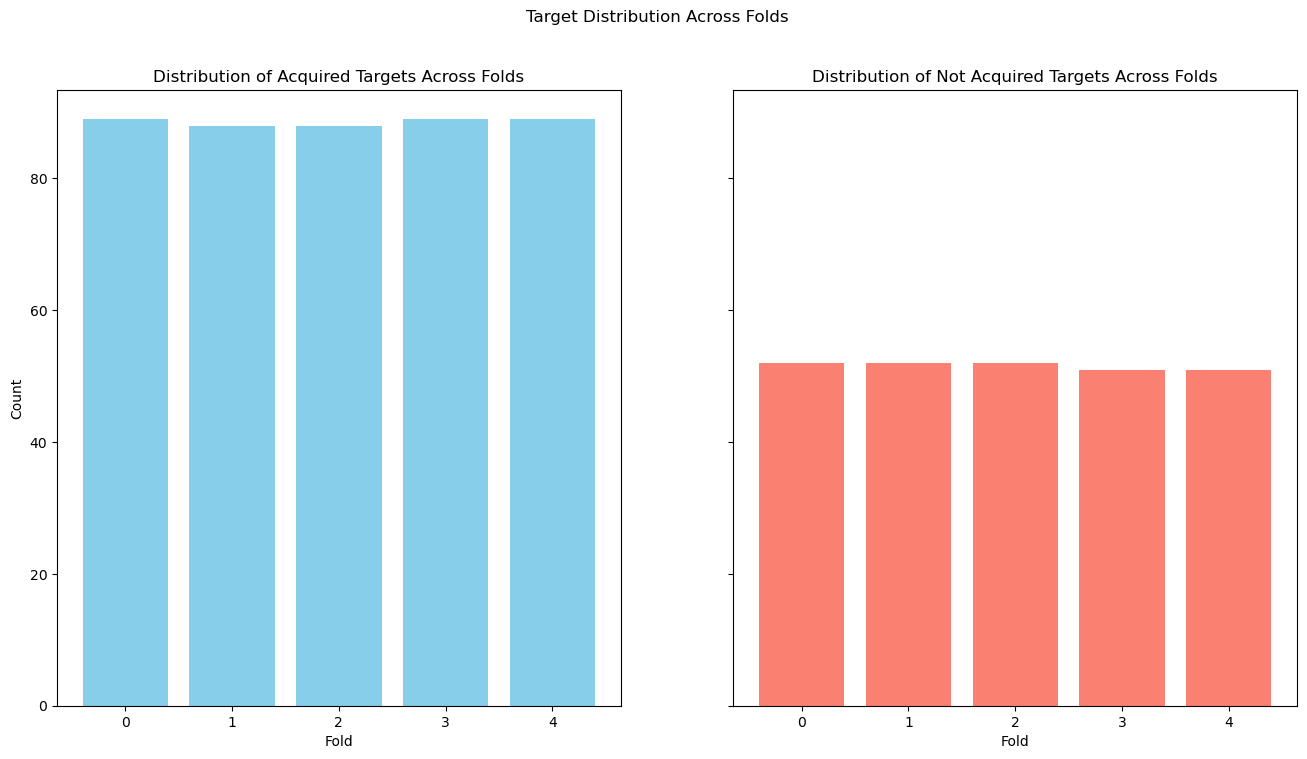

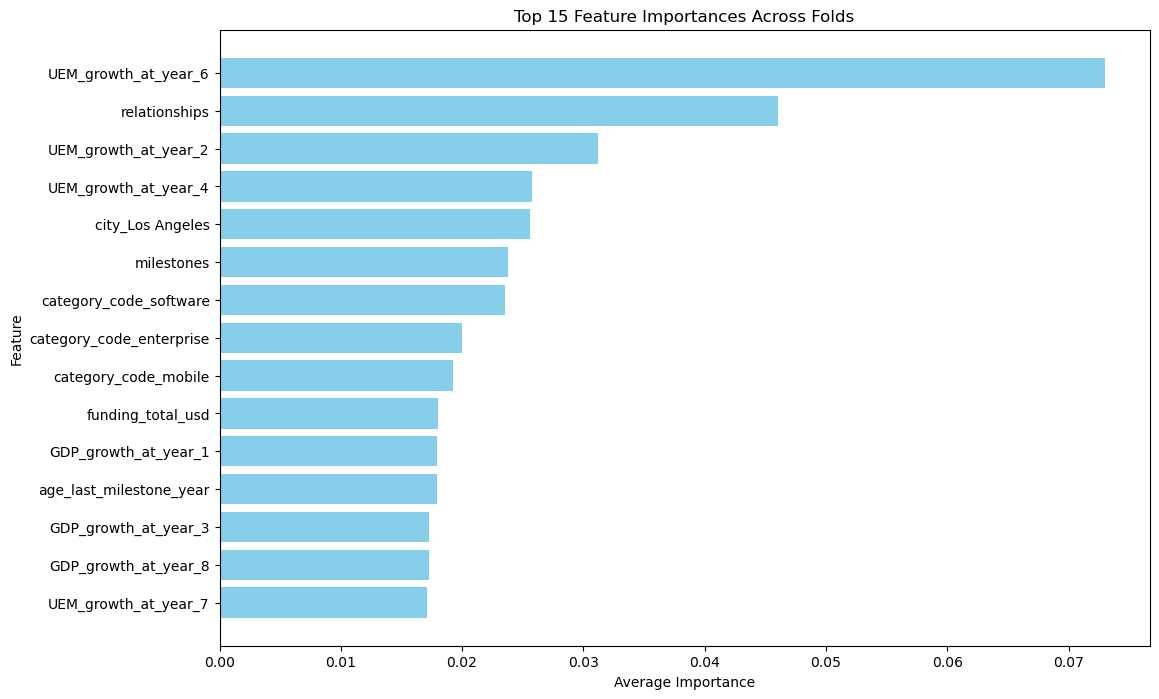

Threshold: 0.5
AUC-ROC: 0.89
Accuracy: 0.87
Balanced Accuracy: 0.83
Precision (Test): 0.84375
Recall (Test): 0.972972972972973
Classification Report (1-fold):
              precision    recall  f1-score   support

           0       0.94      0.69      0.80        65
           1       0.84      0.97      0.90       111

    accuracy                           0.87       176
   macro avg       0.89      0.83      0.85       176
weighted avg       0.88      0.87      0.86       176

Confusion Matrix (1-fold):
[[ 45  20]
 [  3 108]]


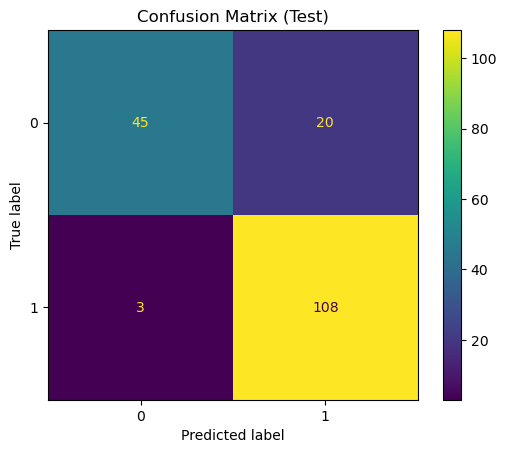

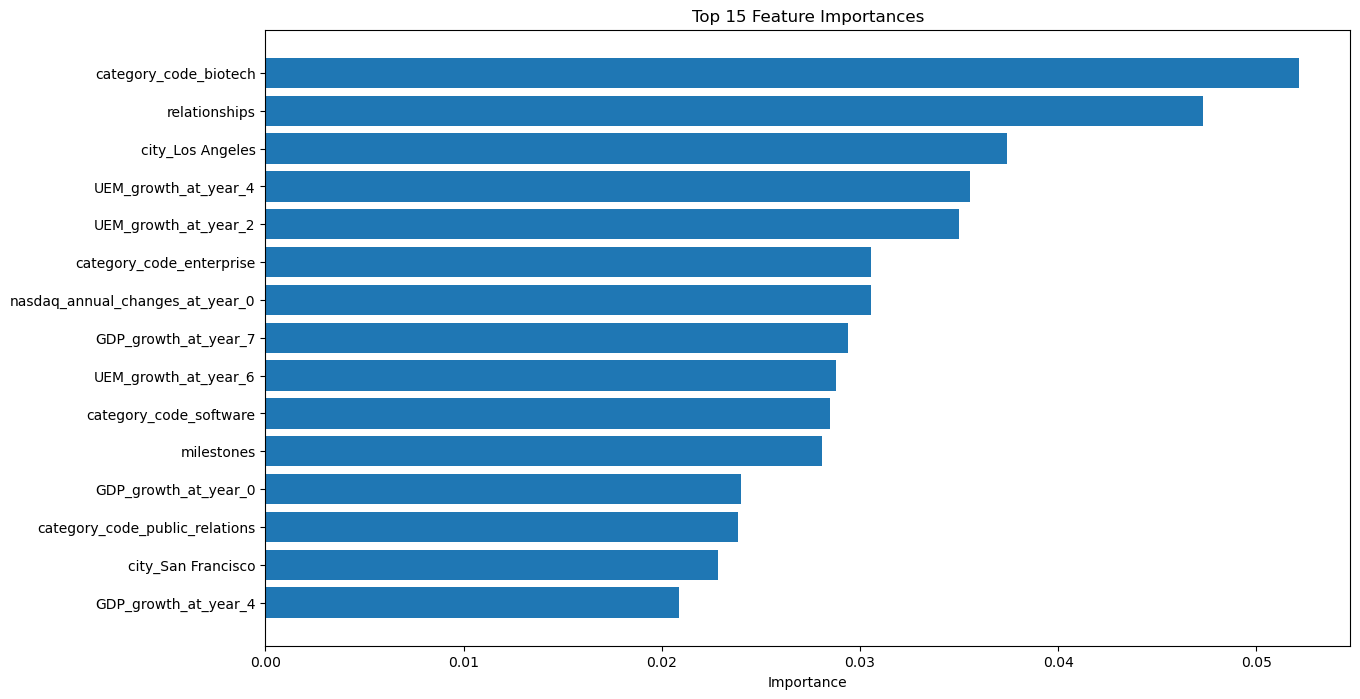

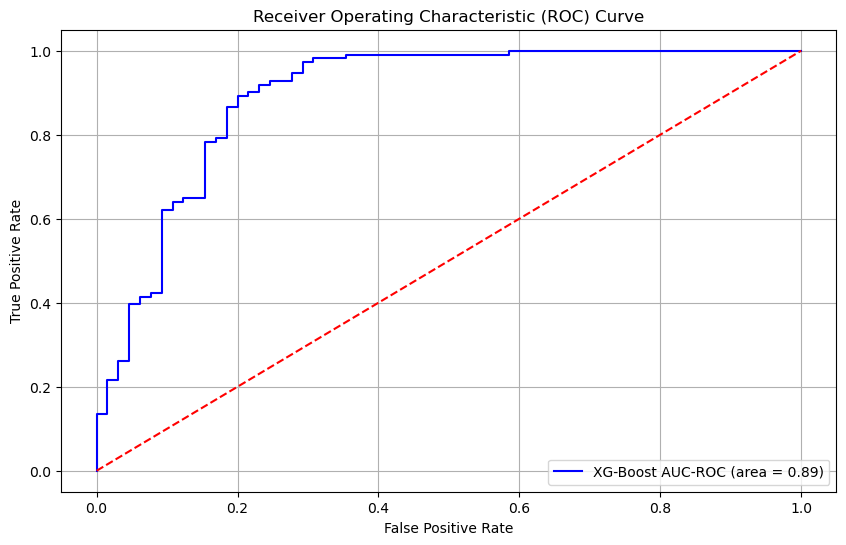

In [11]:

# Initialize your XGBoost model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Perform cross-validation
cv_results_xgb = cross_validate_model_using_StratifiedKFold(xgb_clf, X_train, y_train, n_splits=5, random_state=random_state, 
                                                            print_avg_confusionMatrix=False,
                                                            print_sum_confusionMatrix = False,
                                                            print_target_distribution=True)

# Plot feature importances- 5 fold
plot_feature_importances_kfold_agg(cv_results_xgb['feature_importances'], X_train.columns.tolist(), n_features=15)

# Train the final model on the entire training data
xgb_clf = train_xgb_model(X_train, y_train)

# Predict on the test set
xgb_pred, xgb_prob = predict_model(xgb_clf, X_test)

# Evaluate model on test set
metrics['XGBoost'] = evaluate_model(y_test, xgb_pred, xgb_prob, threshold=0.5, 
                                    print_metrics=True, 
                                    print_report=True, 
                                    show_confusion_mat=True)

metrics['XGBoost']['Kappa'] = round(cv_results_xgb['mean_kappa'], 2)

# Plot feature importances- 1 set
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=15)

# Plot AUC-ROC curve
plot_auc_roc_curve(y_test, xgb_prob, model_name='XG-Boost')

## Random Forest

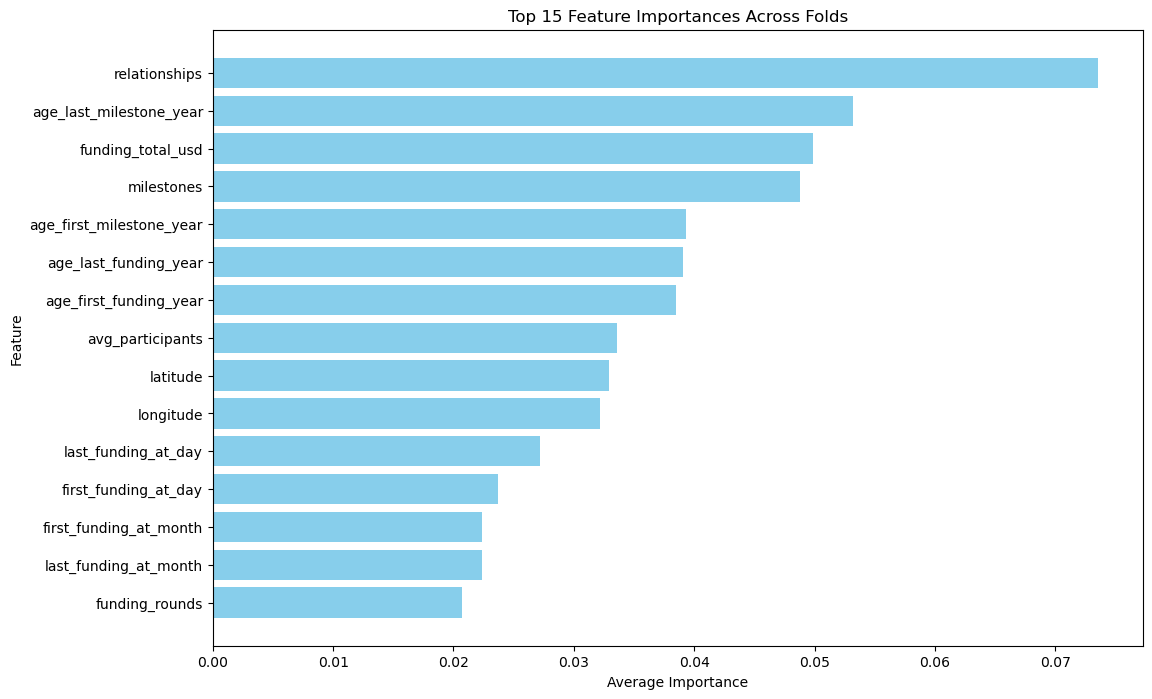

Threshold: 0.5
AUC-ROC: 0.9
Accuracy: 0.85
Balanced Accuracy: 0.81
Precision (Test): 0.823076923076923
Recall (Test): 0.963963963963964
Classification Report (1-fold):
              precision    recall  f1-score   support

           0       0.91      0.65      0.76        65
           1       0.82      0.96      0.89       111

    accuracy                           0.85       176
   macro avg       0.87      0.81      0.82       176
weighted avg       0.86      0.85      0.84       176

Confusion Matrix (1-fold):
[[ 42  23]
 [  4 107]]


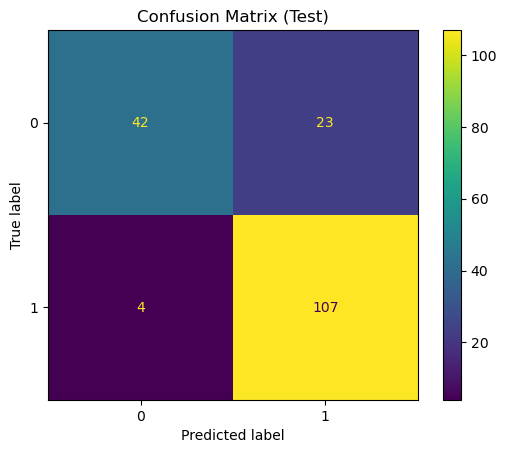

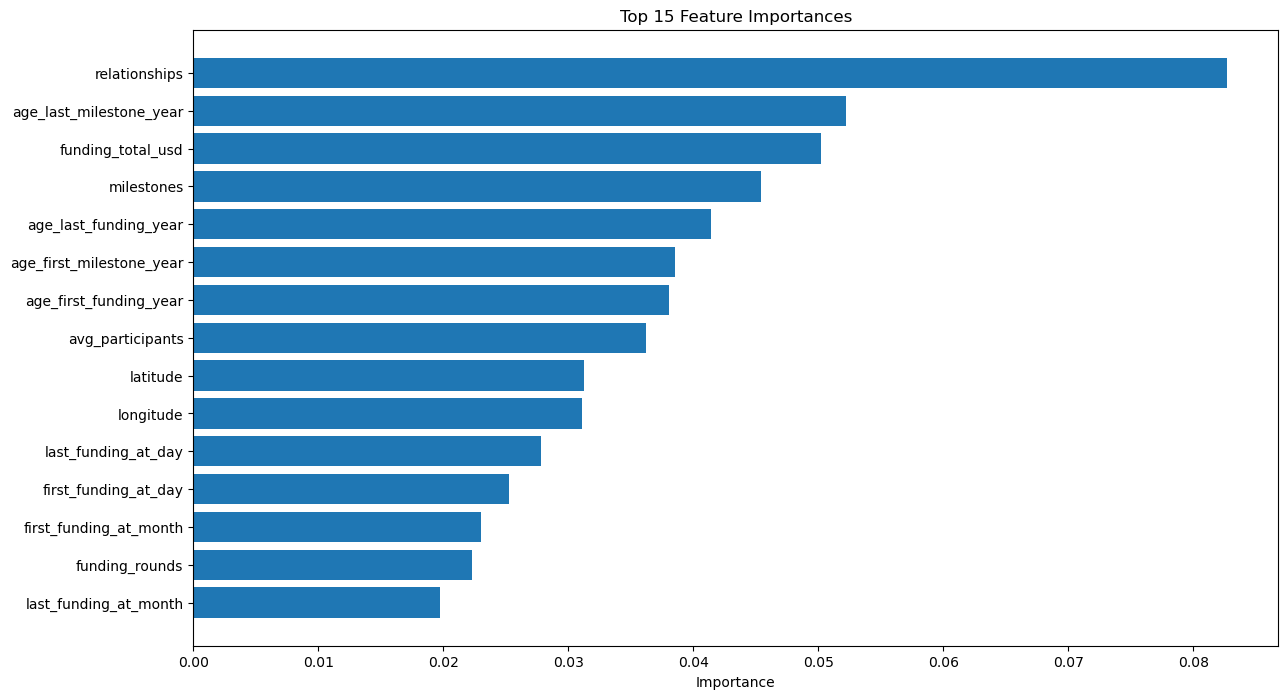

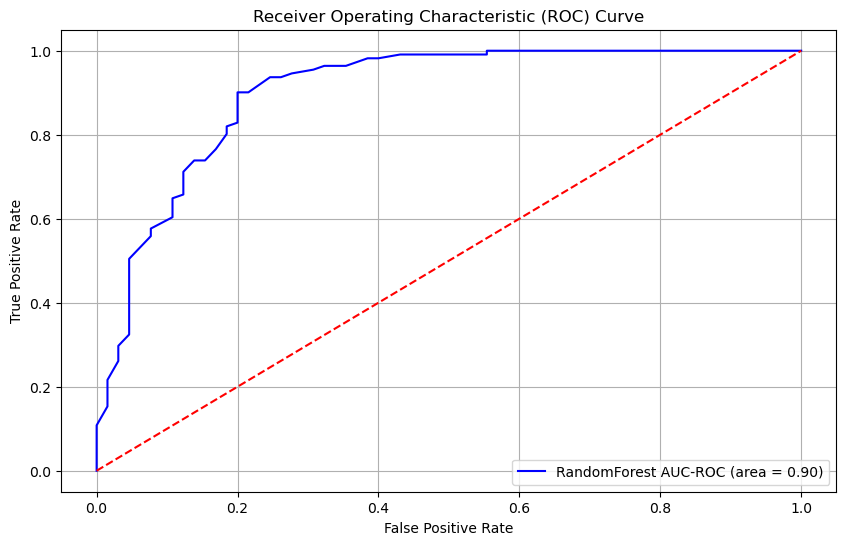

In [12]:

# Initialize your XGBoost model
rf_clf = RandomForestClassifier()

# Perform cross-validation
cv_results_rf = cross_validate_model_using_StratifiedKFold(rf_clf, X_train, y_train, n_splits=5, random_state=random_state, 
                                                            print_avg_confusionMatrix=False,
                                                            print_sum_confusionMatrix = False,
                                                            print_target_distribution=False)

# Plot feature importances- 5 fold
plot_feature_importances_kfold_agg(cv_results_rf['feature_importances'], X_train.columns.tolist(), n_features=15)

# Train the final model on the entire training data
rf_clf = train_rf_model(X_train, y_train)

# Predict on the test set
rf_pred, rf_prob = predict_model(rf_clf, X_test)

# Evaluate model on test set
metrics['RandomForest'] = evaluate_model(y_test, rf_pred, rf_prob, threshold=0.5, 
                                    print_metrics=True, 
                                    print_report=True, 
                                    show_confusion_mat=True)

metrics['RandomForest']['Kappa'] = round(cv_results_rf['mean_kappa'], 2)

# Plot feature importances- 1 set
plot_feature_importances(rf_clf, feature_names=X.columns, num_of_features=15)

# Plot AUC-ROC curve
plot_auc_roc_curve(y_test, rf_prob, model_name='RandomForest')

## SVM

Threshold: 0.5
AUC-ROC: 0.88
Accuracy: 0.79
Balanced Accuracy: 0.74
Precision (Test): 0.7803030303030303
Recall (Test): 0.9279279279279279
Classification Report (1-fold):
              precision    recall  f1-score   support

           0       0.82      0.55      0.66        65
           1       0.78      0.93      0.85       111

    accuracy                           0.79       176
   macro avg       0.80      0.74      0.75       176
weighted avg       0.79      0.79      0.78       176

Confusion Matrix (1-fold):
[[ 36  29]
 [  8 103]]


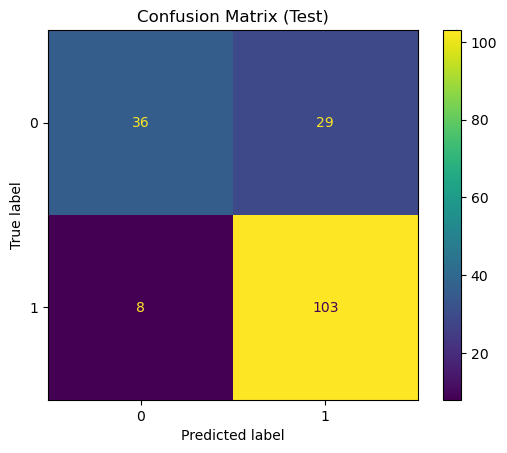

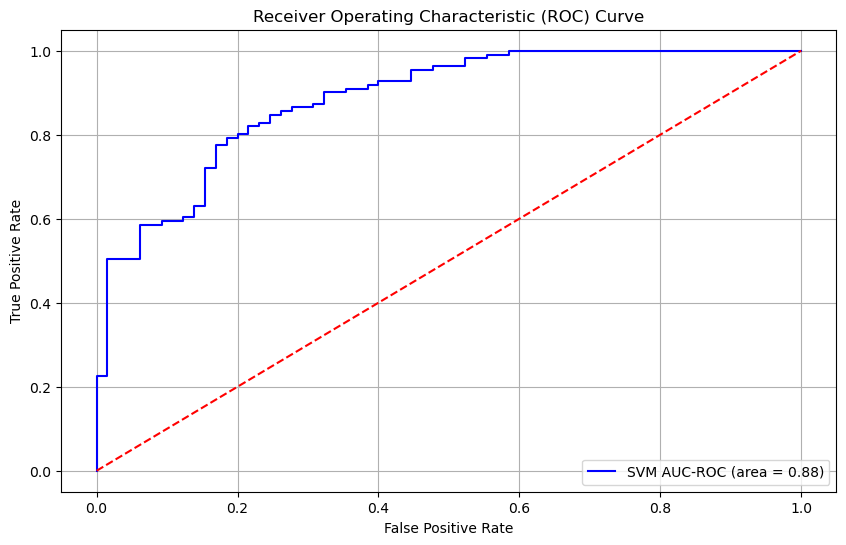

In [13]:

# # Initialize your XGBoost model
svm_clf = SVC(probability=True)

# Perform cross-validation
cv_results_svm = cross_validate_model_using_StratifiedKFold(svm_clf, X_train, y_train, n_splits=5, random_state=random_state, 
                                                            print_avg_confusionMatrix=False,
                                                            print_sum_confusionMatrix = False,
                                                            print_target_distribution=False,
                                                            save_feature_impact_across_folds=False)

# Train the final model on the entire training data
svm_clf = train_svm_model(X_train, y_train)

# Predict on the test set
svm_pred, svm_prob = predict_model(svm_clf, X_test)
metrics['SVM'] = evaluate_model(y_test, svm_pred, svm_prob, threshold=0.5,
                                print_metrics=True, 
                                print_report=True, 
                                show_confusion_mat=True)
metrics['SVM']['Kappa'] = round(cv_results_svm['mean_kappa'], 2)

# Plot AUC-ROC curve
plot_auc_roc_curve(y_test, svm_prob, model_name='SVM')

## Decision Tree

Threshold: 0.5
AUC-ROC: 0.74
Accuracy: 0.78
Balanced Accuracy: 0.74
Precision (Test): 0.7857142857142857
Recall (Test): 0.8918918918918919
Classification Report (1-fold):
              precision    recall  f1-score   support

           0       0.76      0.58      0.66        65
           1       0.79      0.89      0.84       111

    accuracy                           0.78       176
   macro avg       0.77      0.74      0.75       176
weighted avg       0.78      0.78      0.77       176

Confusion Matrix (1-fold):
[[38 27]
 [12 99]]


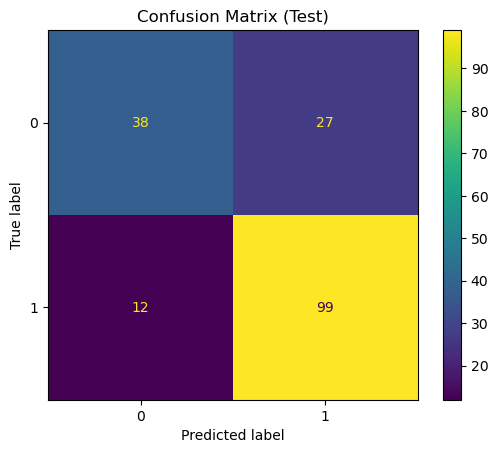

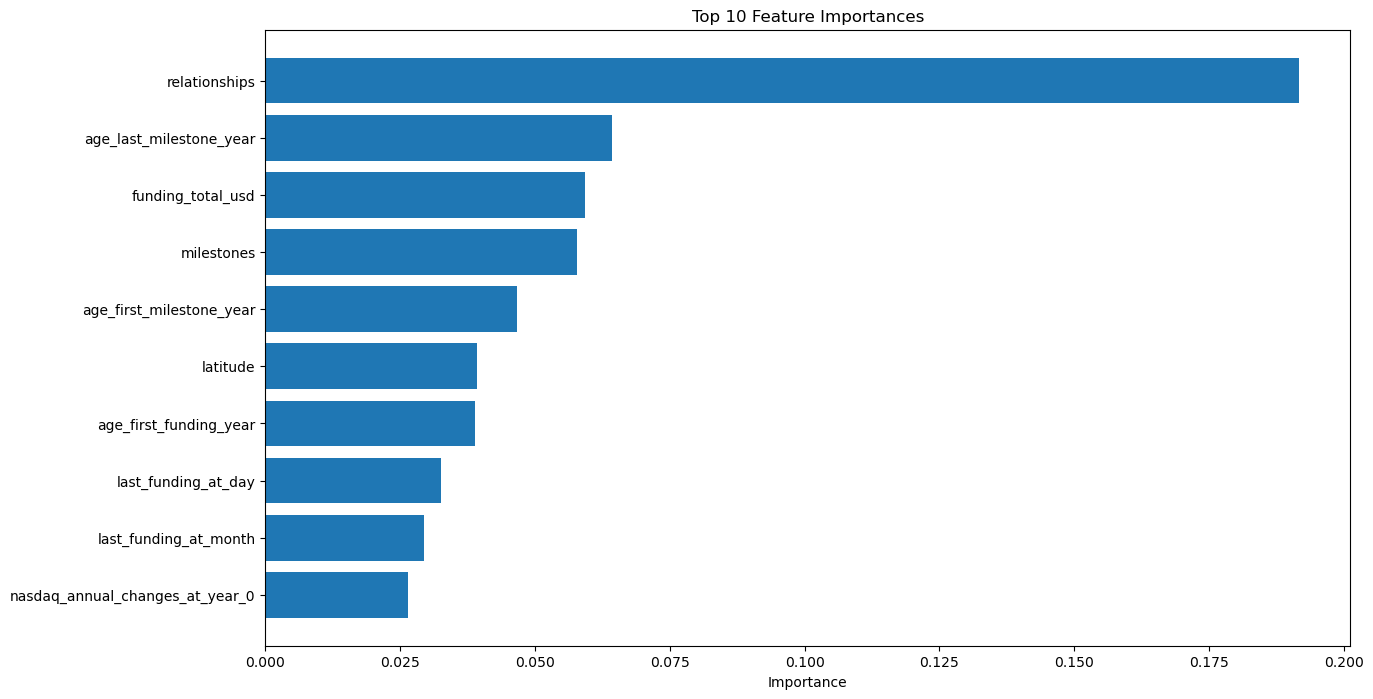

In [14]:
# Initialize your XGBoost model
dt_clf = DecisionTreeClassifier(random_state=42)

# Perform cross-validation
cv_results_dt = cross_validate_model_using_StratifiedKFold(dt_clf, X_train, y_train, n_splits=5, random_state=random_state, 
                                                            print_avg_confusionMatrix=False,
                                                            print_sum_confusionMatrix = False,
                                                            print_target_distribution=False)

# Train the final model on the entire training data
dt_clf = train_decision_tree_model(X_train, y_train)

# Predict on the test set
dt_pred, dt_prob = predict_model(dt_clf, X_test)

# Evaluate model on test set
metrics['DecisionTree'] = evaluate_model(y_test, dt_pred, dt_prob, threshold=0.5, 
                                    print_metrics=True, 
                                    print_report=True, 
                                    show_confusion_mat=True)

metrics['DecisionTree']['Kappa'] = round(cv_results_dt['mean_kappa'], 2)

# Plot feature importances
plot_feature_importances(dt_clf, feature_names=X.columns, num_of_features=10)

# Plot AUC-ROC curve
# plot_auc_roc_curve(y_test, dt_prob, model_name='DecisionTree')

## Ensemble classifiers

### Ensemble selected

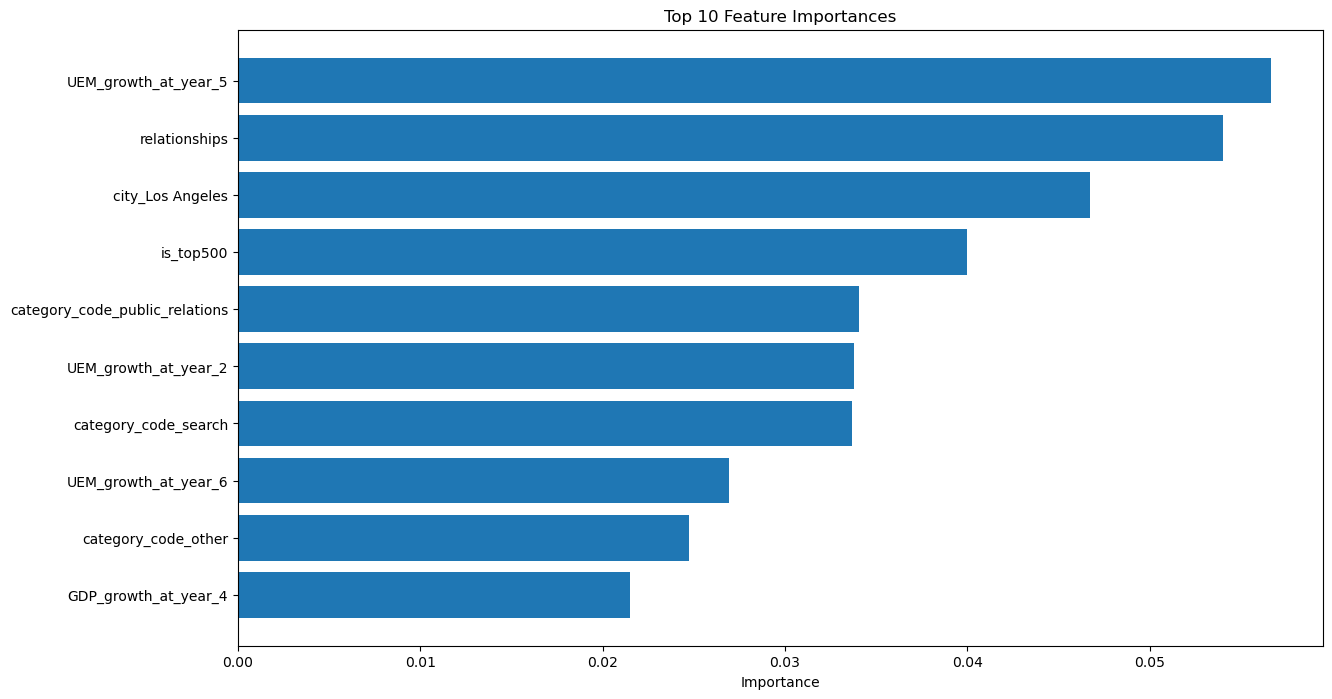

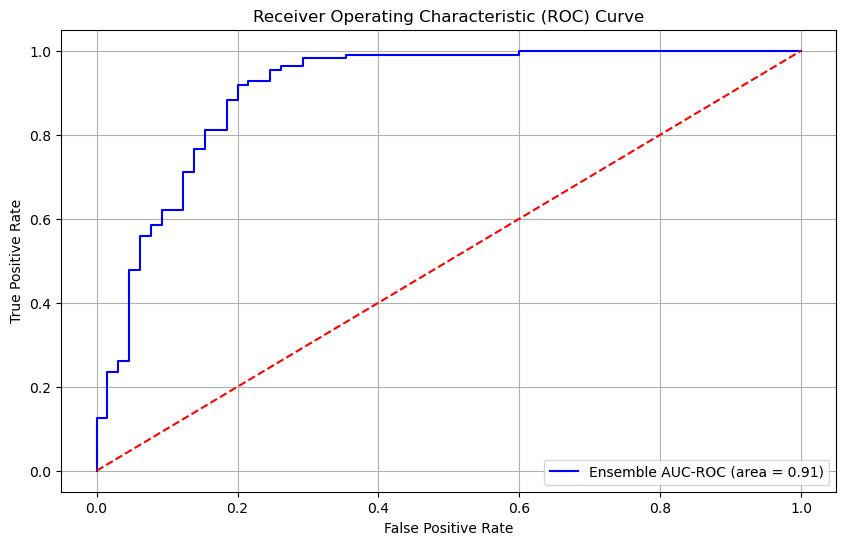

In [15]:
# Example usage:
models = [xgb_clf, rf_clf]  # List of models
ensemble_results = cross_validate_ensemble_using_StratifiedKFold(models, X, y, n_splits=5, random_state=42, 
                                                                 print_avg_confusionMatrix=False, 
                                                                 print_sum_confusionMatrix=False, 
                                                                 print_target_distribution=False)

# Extract ensemble metrics
predictions = np.vstack((xgb_pred, rf_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rf_prob) / 2

# Calculate and print metrics for the ensemble
metrics['Ensemble'] = evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)

plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

## Analyse classifier results

plot all models results graph

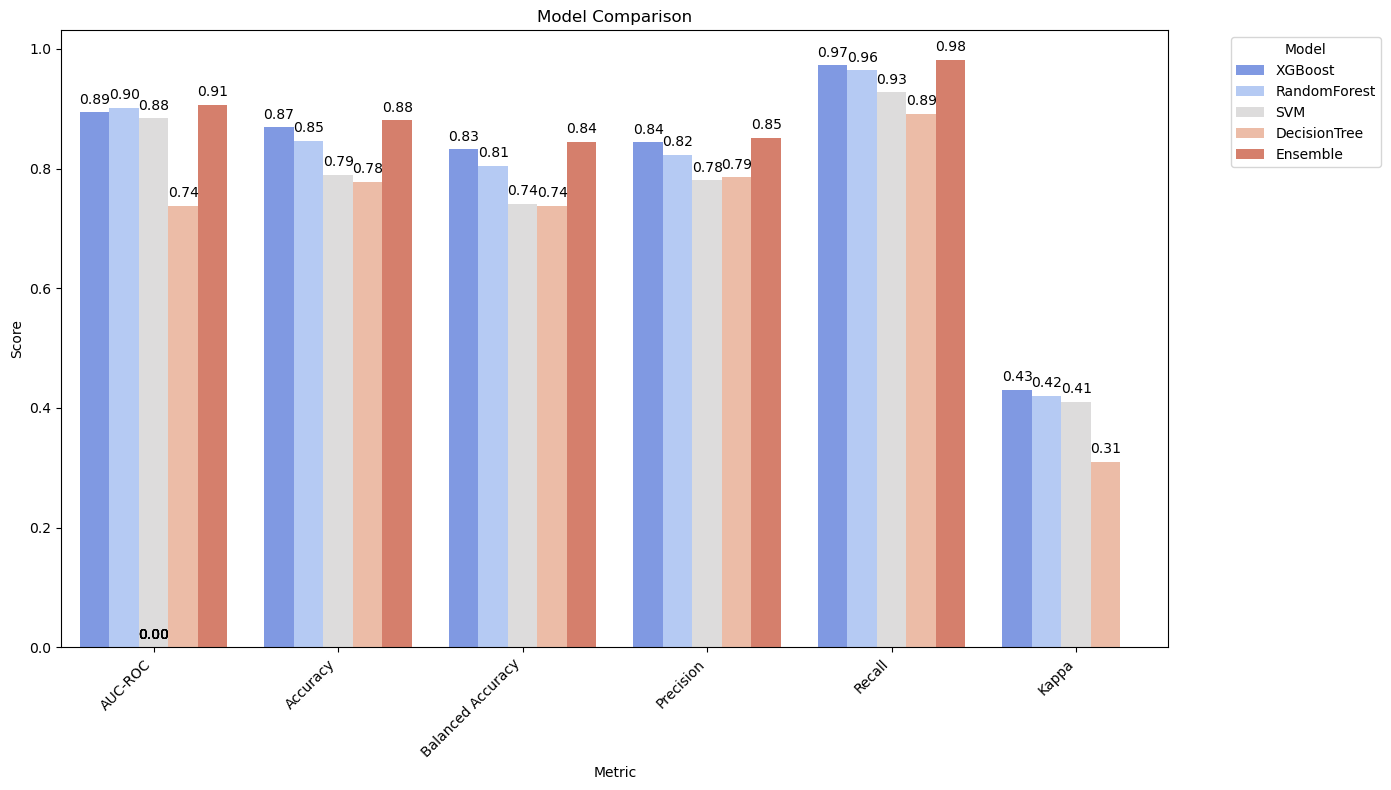

In [16]:
# Define the models
models = ['XGBoost', 'RandomForest', 'SVM', 'DecisionTree', 'Ensemble']
colors = sns.color_palette('coolwarm', n_colors=len(models))

# Create a dictionary to map the model names to the pastel colors
color_mapping = dict(zip(models, colors))

# Convert metrics to DataFrame for plotting
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
metrics_df.columns = ['Model', 'Metric', 'Score']

# Filter out the 'Threshold' metric
metrics_df = metrics_df[metrics_df['Metric'] != 'Threshold']

plt.figure(figsize=(14, 8))

# Use seaborn to create the bar plot with the pastel colors
ax = sns.barplot(
    x='Metric',
    y='Score',
    hue='Model',
    data=metrics_df,
    palette=color_mapping
)

# Add the numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title('Model Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Combine with the original features

In [17]:
import pandas as pd

# Create DataFrame with all features, y_test, and predictions
result_df = pd.DataFrame(X_test, columns=X.columns)
result_df['Actual'] = y_test.values
'''
result_df['Predicted_xgb'] = xgb_pred
result_df['Probability_xgb'] = xgb_prob
result_df['Predicted_rfv2'] = rfv2_pred
result_df['Probability_rfv2'] = rfv2_prob
result_df['Predicted_rf'] = rf_pred
result_df['Probability_rf'] = rf_prob
result_df['Predicted_svm'] = svm_pred
result_df['Probability_svm'] = svm_prob
'''
result_df['Predicted_ensemble'] = ensemble_pred
result_df['Probability_ensemble'] = ensemble_prob

# Display the DataFrame
result_df.head()

,city_Acton,city_Addison,city_Alameda,city_Albuquerque,city_Aliso Viejo,city_Allentown,city_Alpharetta,city_Altamonte Springs,city_Andover,city_Annapolis,...,UEM_growth_at_year_10,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day,Actual,Predicted_ensemble,Probability_ensemble
363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.163177,0.641081,1.376399,0.870541,1.330434,1.096806,-1.038552,1,1,0.951800
143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.004919,-0.244317,0.820003,0.166980,-0.515024,1.381644,0.603472,0,0,0.259231
788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.425566,-0.244317,-1.405583,-0.034038,-0.976388,-1.466739,-0.320167,0,0,0.446332
485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.409052,-0.244317,-1.405583,-0.938616,0.407705,1.666483,1.629737,1,1,0.914444
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026428,-0.687017,-1.127385,-0.938616,-0.515024,-0.612224,-0.935926,1,1,0.944975


### try - drafts

In [18]:
df1 = load_data('../data/startup_data.csv')

In [19]:
result_df_ok = result_df[result_df['Predicted_ensemble'] == result_df['Actual']]
result_df_fail = result_df[result_df['Predicted_ensemble'] != result_df['Actual']]

print(result_df_ok['category_code_biotech'].value_counts() / len(result_df_ok))

category_code_biotech
0.0    0.961039
1.0    0.038961
Name: count, dtype: float64


In [20]:
# Correlation analysis for incorrect predictions, to see which features correlate with the errors, focusing on predicted values
incorrect_corr = (result_df_fail.corr())
print("Correlation in Incorrect Predictions with Predicted Values:\n", incorrect_corr['Predicted_ensemble'].sort_values(ascending=False).head(15))

Correlation in Incorrect Predictions with Predicted Values:
 Predicted_ensemble                 1.000000
Probability_ensemble               0.762210
GDP_growth_at_year_5               0.450726
relationships                      0.377149
has_angel                          0.375000
nasdaq_annual_changes_at_year_0    0.330342
age_first_milestone_year           0.329736
nasdaq_annual_changes_at_year_6    0.283269
nasdaq_annual_changes_at_year_7    0.267103
GDP_growth_at_year_6               0.247603
city_Mountain View                 0.243332
avg_participants                   0.234879
age_last_milestone_year            0.221435
category_code_hardware             0.193649
category_code_network_hosting      0.193649
Name: Predicted_ensemble, dtype: float64


In [21]:
# Add a new column 'predicted_correctly' to the DataFrame
result_df['predicted_correctly'] = (result_df['Predicted_ensemble'] == result_df['Actual']).astype(int)

### The classifier Performance on different categories

                 Total  Correct  Incorrect
web               27.0     25.0        2.0
software          26.0     24.0        2.0
enterprise        15.0     13.0        2.0
games_video       10.0     10.0        0.0
mobile            10.0      9.0        1.0
semiconductor      9.0      8.0        1.0
network_hosting    9.0      7.0        2.0
ecommerce          9.0      9.0        0.0
biotech            7.0      6.0        1.0
hardware           7.0      5.0        2.0
advertising        6.0      6.0        0.0


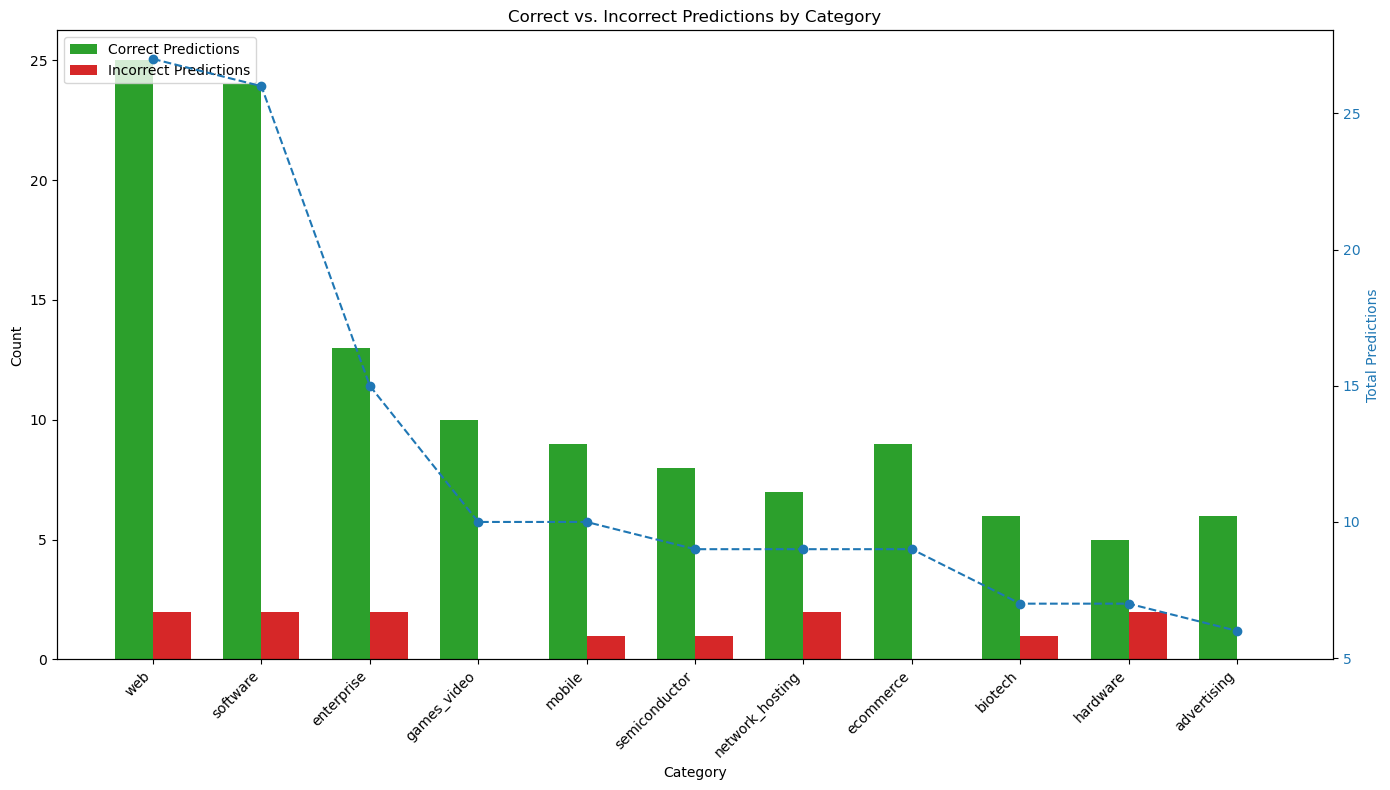

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the total predictions for each category and the correct/incorrect prediction counts
category_analysis = {}

for column in result_df.columns:
    if column.startswith('category_code_'):
        total = result_df[column].sum()  # total instances of this category
        correct = result_df[result_df['predicted_correctly'] == 1][column].sum()
        incorrect = total - correct
        category_name = column.replace('category_code_', '')
        category_analysis[category_name] = {'Total': total, 'Correct': correct, 'Incorrect': incorrect}

# Convert to DataFrame for better visualization
category_df = pd.DataFrame.from_dict(category_analysis, orient='index')
category_df = category_df.sort_values(by='Total', ascending=False)

# Filter out categories with total prediction count <5
category_df = category_df[category_df['Total'] > 5]

print(category_df)

# Plot the correct and incorrect predictions side by side with a secondary y-axis for total predictions
fig, ax1 = plt.subplots(figsize=(14, 8))

bar_width = 0.35
index = np.arange(len(category_df.index))

# Bars for correct predictions
bars1 = ax1.bar(index, category_df['Correct'], bar_width, label='Correct Predictions', color='tab:green')

# Bars for incorrect predictions
bars2 = ax1.bar(index + bar_width, category_df['Incorrect'], bar_width, label='Incorrect Predictions', color='tab:red')

# Primary y-axis
ax1.set_xlabel('Category')
ax1.set_ylabel('Count')
ax1.set_title('Correct vs. Incorrect Predictions by Category')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(category_df.index, rotation=45, ha='right')
ax1.legend(loc='upper left')

# Secondary y-axis for total predictions
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Total Predictions', color=color)
ax2.plot(index + bar_width / 2, category_df['Total'], color=color, marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout()
plt.show()


#### same for 5-fold results aggregation

/tmp/ipykernel_232992/12005512.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted'] = ensemble_pred
/tmp/ipykernel_232992/12005512.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted'] = ensemble_pred
/tmp/ipykernel_232992/12005512.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

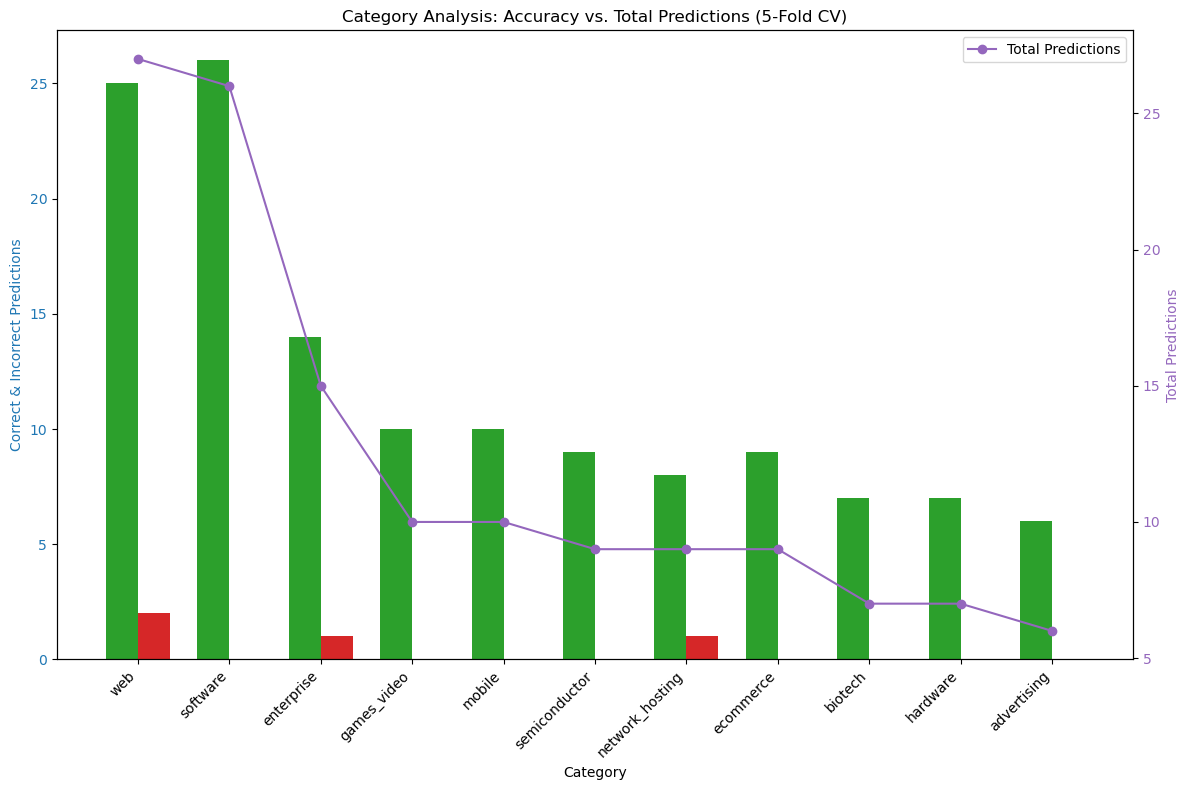

In [23]:
from sklearn.model_selection import KFold
from scipy.stats import mode

# Assuming your result_df has the necessary columns to be used as features
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

category_analysis_cv = []

for train_index, test_index in kf.split(result_df):
    train_df, test_df = result_df.iloc[train_index], result_df.iloc[test_index]

    # Ensure only the original feature columns are used
    feature_columns = X.columns

    X_train, y_train = train_df[feature_columns], train_df['Actual']
    X_test, y_test = test_df[feature_columns], test_df['Actual']

    # Replace this with your actual model fitting and predicting code
    xgb_pred, xgb_prob = predict_model(xgb_clf, X_test)
    rf_pred, rf_prob = predict_model(rf_clf, X_test)
    # svm_pred, svm_prob = predict_model(svm_clf, X_test)

    # Stack the predictions into a matrix
    predictions = np.vstack((xgb_pred, rf_pred)).T

    # Majority voting
    ensemble_pred, _ = mode(predictions, axis=1)
    ensemble_pred = ensemble_pred.ravel()

    # Store the predicted and actual values in test_df
    test_df['Predicted'] = ensemble_pred

    # Now calculate the statistics for this fold
    for column in result_df.columns:
        if column.startswith('category_code_'):
            total = test_df[column].sum()  # total instances of this category in the fold
            correct = test_df[(test_df['Predicted'] == test_df['Actual'])][column].sum()
            incorrect = total - correct
            accuracy = correct / total if total > 0 else 0
            category_name = column.replace('category_code_', '')
            category_analysis_cv.append({'Category': category_name, 'Total': total, 'Correct': correct, 'Incorrect': incorrect, 'Accuracy': accuracy})

# Aggregate results across folds
category_df_cv = pd.DataFrame(category_analysis_cv)
category_df_cv = category_df_cv.groupby('Category').sum()
category_df_cv['Accuracy'] = category_df_cv['Correct'] / category_df_cv['Total']

# Sort by the most common categories
category_df_cv = category_df_cv.sort_values(by='Total', ascending=False)

# Filter out categories with total prediction count of <5
category_df_cv = category_df_cv[category_df_cv['Total'] > 5]

# Set the width for the bars
bar_width = 0.35

# Plotting Correct vs Incorrect predictions side by side
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Category')
ax1.set_ylabel('Correct & Incorrect Predictions', color=color)

# Set the positions for the bars
index = np.arange(len(category_df_cv))

# Plot the bars side by side
ax1.bar(index - bar_width/2, category_df_cv['Correct'], bar_width, color='tab:green', label='Correct')
ax1.bar(index + bar_width/2, category_df_cv['Incorrect'], bar_width, color='tab:red', label='Incorrect')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(index)
ax1.set_xticklabels(category_df_cv.index, rotation=45, ha='right')

# Create a second y-axis for the total counts
ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Total Predictions', color=color)
ax2.plot(index, category_df_cv['Total'], color=color, marker='o', label='Total Predictions')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Category Analysis: Accuracy vs. Total Predictions (5-Fold CV)')
fig.tight_layout()
plt.legend()
plt.show()



In [24]:
df1.category_code.value_counts()

category_code
software            153
web                 144
mobile               79
enterprise           73
advertising          62
games_video          52
semiconductor        35
network_hosting      34
biotech              34
hardware             27
ecommerce            25
public_relations     25
cleantech            23
security             19
analytics            19
social               14
search               12
other                11
messaging            11
fashion               8
travel                8
news                  8
medical               7
photo_video           7
music                 6
finance               6
education             4
consulting            3
real_estate           3
health                3
automotive            2
manufacturing         2
transportation        2
hospitality           1
sports                1
Name: count, dtype: int64

In [25]:
result_df_fail['category_code_biotech'] = result_df_fail.category_code_biotech.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['category_code_biotech'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_biotech'].value_counts() )

category_code_biotech
0    21
1     1
Name: count, dtype: int64


/tmp/ipykernel_232992/3361802483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_fail['category_code_biotech'] = result_df_fail.category_code_biotech.apply(lambda x: 1 if x > 0.6 else 0)


In [26]:
result_df_fail['category_code_software'] = result_df_fail.category_code_software.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['category_code_software'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_software'].value_counts() )

category_code_software
0    20
1     2
Name: count, dtype: int64


/tmp/ipykernel_232992/3962302272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_fail['category_code_software'] = result_df_fail.category_code_software.apply(lambda x: 1 if x > 0.6 else 0)


In [27]:
result_df_fail['category_code_other'] = result_df_fail.category_code_other.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['is_othercategory'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_other'].value_counts() )

category_code_other
0    20
1     2
Name: count, dtype: int64


/tmp/ipykernel_232992/1649161994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_fail['category_code_other'] = result_df_fail.category_code_other.apply(lambda x: 1 if x > 0.6 else 0)


In [28]:
# # Create label
df['status_code'] = df['status'].map({'acquired': 1, 'closed': 0})
print_correlations_Spearman_and_Pearson(df['GDP_growth_at_year_0'], df['status_code'])
print_correlations_Spearman_and_Pearson(df['relationships'], df['status_code'])
print_correlations_Spearman_and_Pearson(df['avg_participants'], df['status_code'])
print_correlations_Spearman_and_Pearson(df['has_roundC'], df['status_code'])
print_correlations_Spearman_and_Pearson(df['has_roundD'], df['status_code'])

Spearman correlation: -0.02395745272281034, p-value: 0.4672459574613621
Pearson correlation: -0.044394064377681786, p-value: 0.17779704682205782
Spearman correlation: 0.466947609250253, p-value: 3.63257569528578e-51
Pearson correlation: 0.3604336437709972, p-value: 1.0678742927713986e-29
Spearman correlation: 0.226498446014084, p-value: 3.3408410636154857e-12
Pearson correlation: 0.18599162866024185, p-value: 1.2506004126542012e-08
Spearman correlation: 0.1659015104590796, p-value: 4.008095143462745e-07
Pearson correlation: 0.1659015104590796, p-value: 4.0080951434626525e-07
Spearman correlation: 0.13994040612339836, p-value: 1.9832511468107988e-05
Pearson correlation: 0.13994040612339836, p-value: 1.9832511468109062e-05


In [29]:
result_df.category_code_other.value_counts()

category_code_other
0.0    173
1.0      3
Name: count, dtype: int64

# Regressors

In [30]:
'''
'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate',
'category_code', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory',
'has_roundB', 'has_roundC', 'has_roundD', 'has_VC', 'has_angel', 'has_roundA',
'''
'''
'closed_at', 'age_first_funding_year', 'age_last_funding_year',
'age_first_milestone_year', 'age_last_milestone_year', 'funding_rounds', 'funding_total_usd',
'milestones', 'avg_participants',
'''

"\n'closed_at', 'age_first_funding_year', 'age_last_funding_year',\n'age_first_milestone_year', 'age_last_milestone_year', 'funding_rounds', 'funding_total_usd',\n'milestones', 'avg_participants',\n"

## predict age_first_funding_year

Cross-Validated MSE: 0.5130
Custom Accuracy within 1 year (Cross-Validation): 84.51%
Mean Squared Error (MSE): 0.41
Mean Absolute Error (MAE): 0.39
R-squared (R²): 0.9
Custom Accuracy (within ±10%): 73.51%


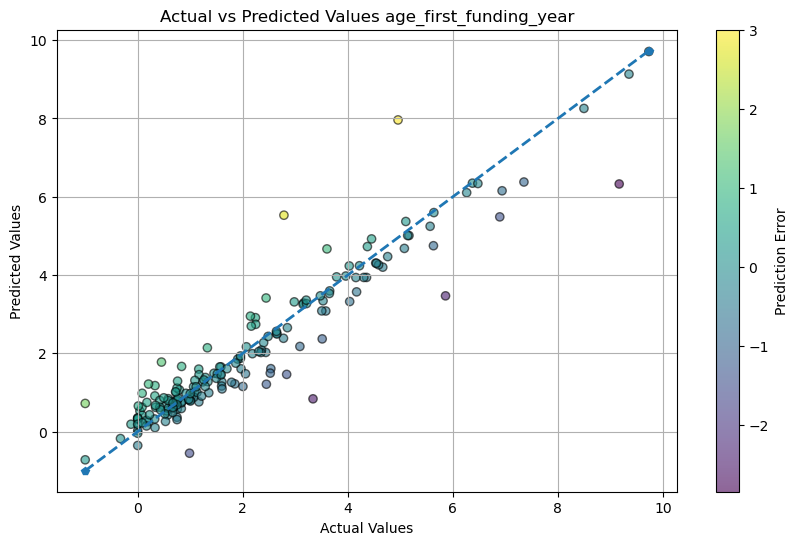

<Figure size 1000x800 with 0 Axes>

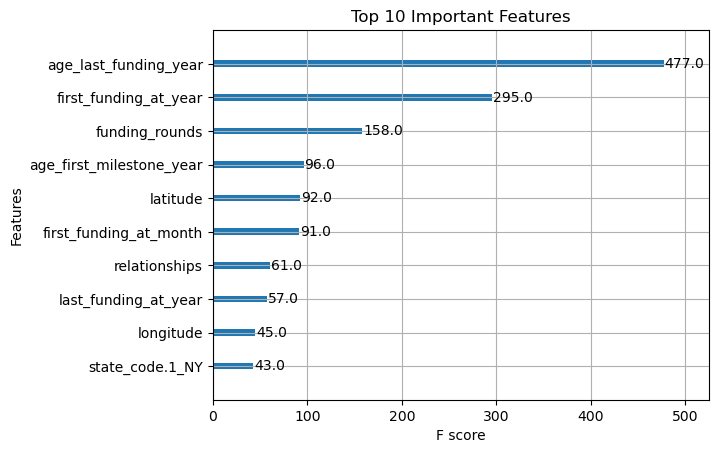

Custom Accuracy within 1 year (Test Set): 87.57%


In [31]:
import numpy as np
from sklearn.model_selection import cross_val_predict, KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Create target
y = df['age_first_funding_year']
df1 = df.drop('age_first_funding_year', axis=1)

# Preprocess the data
X = preprocess_data(df1, useKNNImputer=True)

# Define the cross-validation strategy (k-fold with 5 splits)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(random_state=random_state)

# Perform cross-validation and get the predictions on the test set
y_pred_cv = cross_val_predict(xgb_regressor, X, y, cv=kf)

# Calculate mean squared error for cross-validated predictions
mse_cv = mean_squared_error(y, y_pred_cv)
print(f"Cross-Validated MSE: {mse_cv:.4f}")

# Custom accuracy for cross-validation
accuracy_abs_cv = (abs((y_pred_cv - y) / y) <= 1).mean()
print(f"Custom Accuracy within 1 year (Cross-Validation): {accuracy_abs_cv * 100:.2f}%")

# Now train and evaluate the model normally
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'age_first_funding_year', tolerance=0.4)

# Custom accuracy on the test set
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Custom Accuracy within 1 year (Test Set): {accuracy_abs * 100:.2f}%")

Mean Squared Error (MSE): 0.41
Mean Absolute Error (MAE): 0.39
R-squared (R²): 0.9
Custom Accuracy (within ±10%): 73.51%


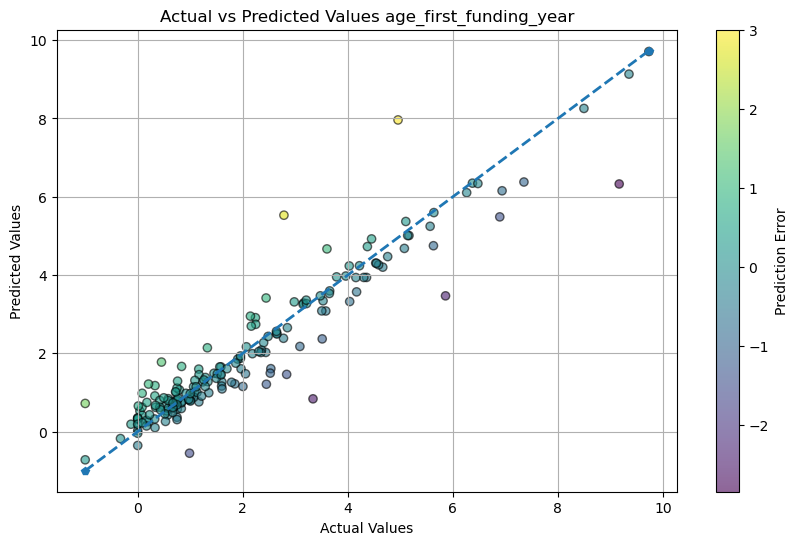

<Figure size 1000x800 with 0 Axes>

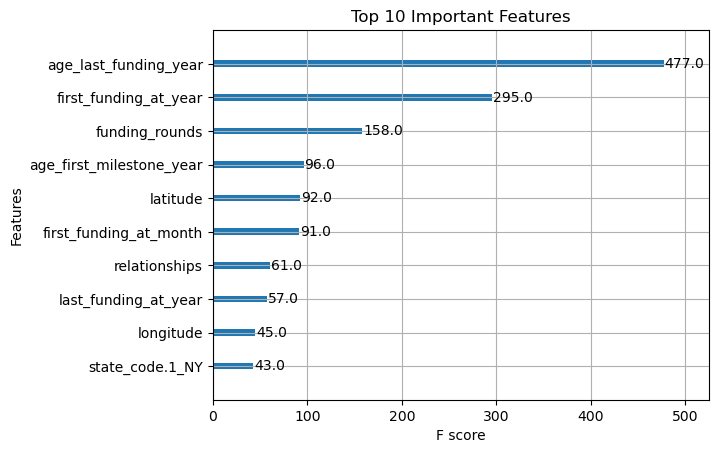

Custom Accuracy within 1 year: 87.57%


In [32]:
# Create target
y = df['age_first_funding_year']
df1 = df.drop('age_first_funding_year', axis=1)
# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'age_first_funding_year', tolerance = 0.4)

accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Custom Accuracy within {1} year: {accuracy_abs * 100:.2f}%")

## age_last_funding_year

Mean Squared Error (MSE): 0.31
Mean Absolute Error (MAE): 0.4
R-squared (R²): 0.95
Custom Accuracy (within ±10%): 88.11%


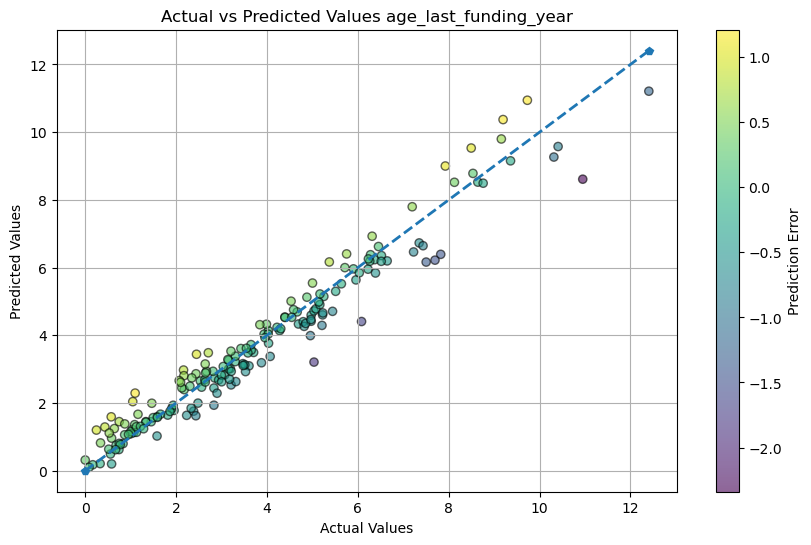

<Figure size 1000x800 with 0 Axes>

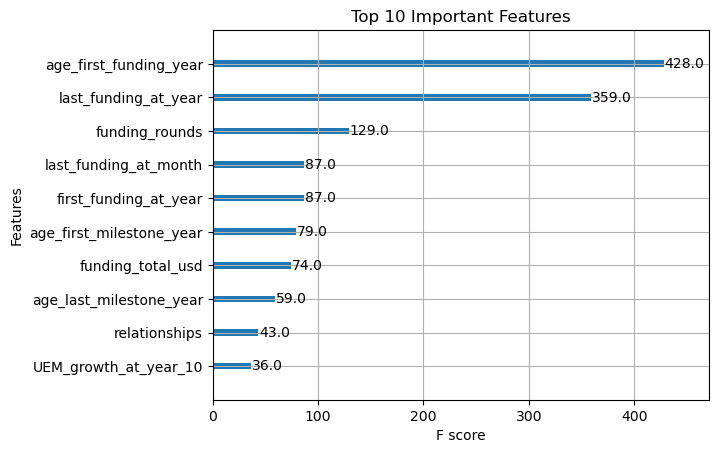

Accuracy within 1 year: 96.22%


In [33]:
# Create target
y = df['age_last_funding_year']
df1 = df.drop('age_last_funding_year', axis=1)
# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'age_last_funding_year', tolerance = 0.3)
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} year: {accuracy_abs * 100:.2f}%")

## funding_rounds

771
Mean Squared Error (MSE): 2.35
Mean Absolute Error (MAE): 0.96
R-squared (R²): 0.7
Custom Accuracy (within ±10%): 55.48%


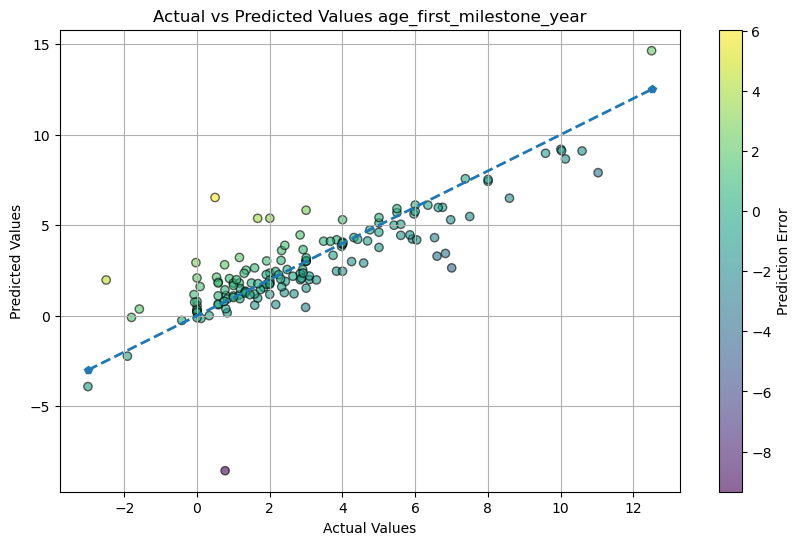

<Figure size 1000x800 with 0 Axes>

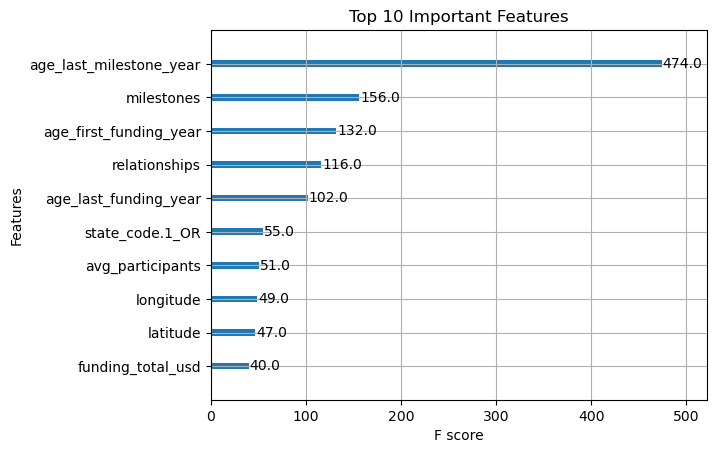

Accuracy within 1 round: 83.23%


In [34]:
# Create target
df1 = df.copy()

# Drop rows where 'age_first_milestone_year' is NaN
df1.dropna(subset=['age_first_milestone_year'], inplace=True)
print(len(df1))
y = df1['age_first_milestone_year']
df1 = df1.drop('age_first_milestone_year', axis=1)
# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'age_first_milestone_year', tolerance = 0.3)
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} round: {accuracy_abs * 100:.2f}%")

## funding_total_usd

Mean Squared Error (MSE): 1688192122066178.5
Mean Absolute Error (MAE): 12889594.28
R-squared (R²): 0.05
Custom Accuracy (within ±10%): 37.30%


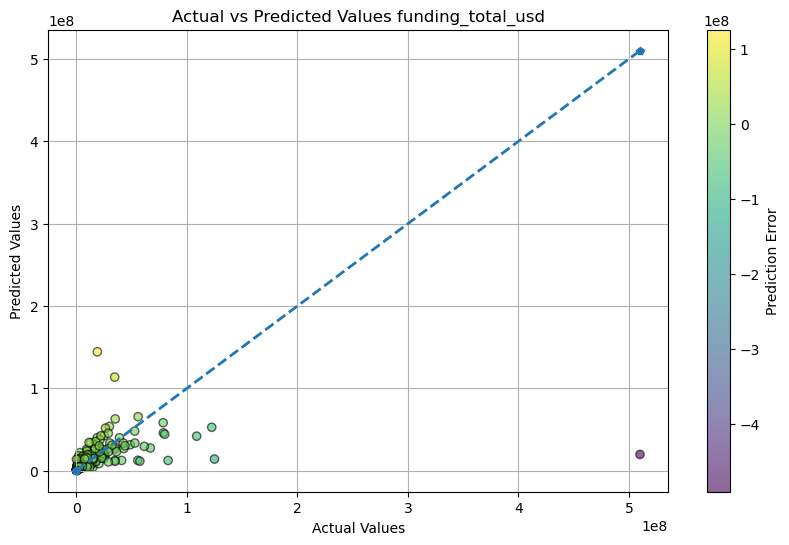

<Figure size 1000x800 with 0 Axes>

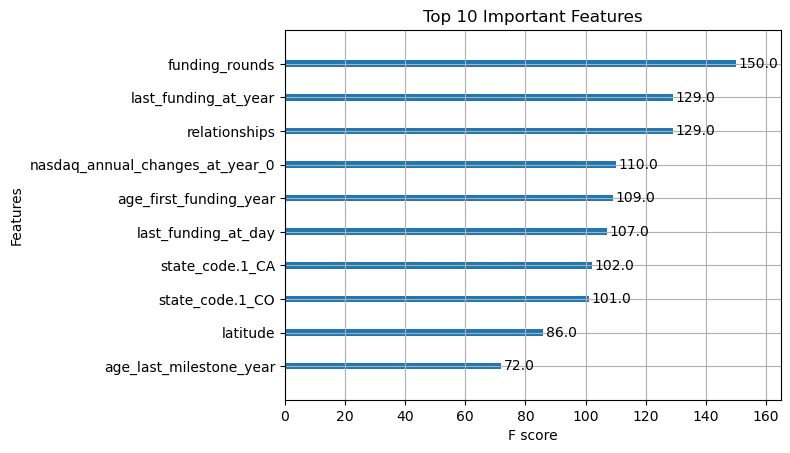

Accuracy within 1 mln usd: 68.65%


In [35]:
# Preprocess and split the data train and evaluate:
X = preprocess_data(df, useKNNImputer=True)
y = df['funding_total_usd'] # Create target
X = X.drop('funding_total_usd', axis=1)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'funding_total_usd', tolerance = 0.4)
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} mln usd: {accuracy_abs * 100:.2f}%")

## milestones

Mean Squared Error (MSE): 0.72
Mean Absolute Error (MAE): 0.63
R-squared (R²): 0.5
Custom Accuracy (within ±10%): 21.62%


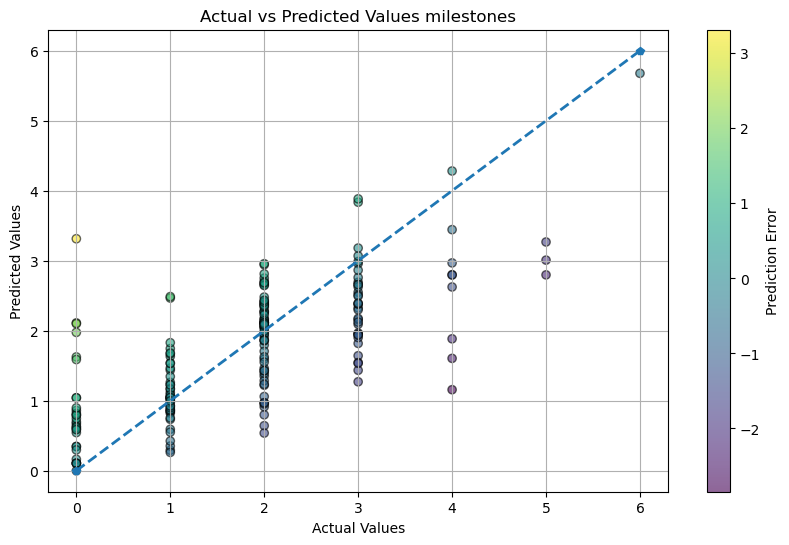

<Figure size 1000x800 with 0 Axes>

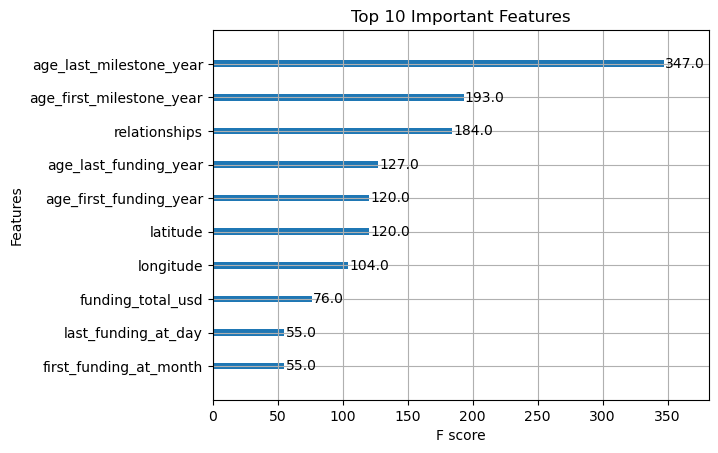

Accuracy within 1 mln usd: 82.70%


In [36]:
# Create target
y = df['milestones']
df1 = df.copy()
df1 = df1.drop('milestones', axis=1)

# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'milestones')
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} mln usd: {accuracy_abs * 100:.2f}%")

In [37]:
'age_first_funding_year', 'age_last_funding_year',
'age_first_milestone_year', 'age_last_milestone_year', 'funding_rounds', 'funding_total_usd',
'milestones'

'milestones'